In [3]:
import os
import threading
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# import seaborn as sns
from osgeo import gdal


In [23]:
print(os.getcwd()) 

os.chdir('E:\热浪\data\WBGT\Temp')


E:\热浪\data\WBGT\Temp


In [24]:
import re
import os
import glob
import pandas as pd


# 为csv文件添加省份字段


# for file in glob.glob('./Daily*.csv'):
#     (
#         pd
#         .read_csv(file)
#         .assign(name=re.findall('Daily-(.*?)-', file)[0])
#         .to_csv('处理后_'+os.path.split(file)[-1])
#           )


In [25]:
# #合并csv文件

# os.chdir(r'E:\热浪\data\WBGT\Temp\temp-1980-1999')   
# extension = 'csv'
# all_filenames = [i for i in glob.glob('处理后_Daily-*.{}'.format(extension))]
# #combine all files in the list
# combined_csv = pd.concat([pd.read_csv(f,low_memory=False) for f in all_filenames ])
# #export to csv
# combined_csv.to_csv( "Temp-Daily-1980-1999.csv", index=False)

In [57]:
# 打开 1980-1999每日数据 
os.chdir(r'E:\热浪\data\WBGT\Temp\temp-1980-1999')  
WBGT_data = pd.read_csv(r'Temp-Daily-1980-1999.csv',engine='python')
WBGT_Daily_data = pd.DataFrame(WBGT_data)
Daily_data = WBGT_Daily_data.groupby(['name'])
threshold = Daily_data["C"].quantile(0.9)
# threshold.head()
# print(threshold)

In [64]:
threshold.to_csv(r'threshold1980-1999.csv')

threshold = pd.read_csv('threshold1980-1999.csv').set_index('name')
threshold.head()

,Unnamed: 0,C
name,,
Anhui,0,36.1299
Beijing,1,35.5559
Chongqing,2,36.0367
Fujian,3,37.0873
Gansu,4,38.2525


In [65]:
# 打开 1980-1999每日数据 计算历史时期的温度阈值
os.chdir(r'E:\热浪\data\WBGT\Temp')
demo = pd.read_csv('Temp-Daily-1980-2019.csv', parse_dates=['system:time_start']).iloc[:, 1:]
demo.head(3)


,system:time_start,C,name
0,1980-05-01,27.371,Anhui
1,1980-05-02,26.961,Anhui
2,1980-05-03,29.581,Anhui


In [66]:
from sklearn.cluster import DBSCAN

In [67]:
def extract_info(group_name, group_df):
    
    # 初始化DBSCAN模型
    model = DBSCAN(eps=1.1, min_samples=1, n_jobs=-2)
    
    group_df = (
        group_df
        # 计算聚类用量化日期
        .assign(
            day_num=(group_df['system:time_start'] - group_df['system:time_start'].min()).dt.days
        )
        # 保留超出阈值的记录
        .query('C > {}'.format(threshold.at[group_name, 'C']))
        .assign(
            # 利用DBSCAN快速计算得到日期连续的记录片段
            cluster_label=lambda df: model.fit_predict(df['day_num'].values.reshape(-1, 1))
        )
        .groupby('cluster_label')
        .filter(lambda df: df.shape[0] >= 3)
        # 按年度统计各项指标
        .assign(year=lambda df: df['system:time_start'].dt.year)
        .groupby('year')
        .agg(
            发生频次=pd.NamedAgg(column='cluster_label', aggfunc='nunique'),
            总和持续天数=pd.NamedAgg(column='cluster_label', aggfunc='size'),
            平均持续天数=pd.NamedAgg(column='cluster_label', aggfunc=lambda s: s.size / s.nunique())
        )
        .assign(地区=group_name)
        .join(
            # 补充不同计算逻辑下的高温均值指标
            group_df
            .assign(year=lambda df: df['system:time_start'].dt.year)
            # 保留超出阈值的记录
            .query('C > {}'.format(threshold.at[group_name, 'C']))
            .groupby('year')
            .agg(高温均值=pd.NamedAgg(column='C', aggfunc='mean'))
        )
        .reset_index(drop=False)
    )
    
    return group_df

In [70]:
result = (
    pd
    .concat(
        [
            extract_info(*group)
            for group in demo.groupby('name')
        ],
        ignore_index=True
    )
)
result.to_csv(r'分省分年最高温热浪事件.csv')
result


,year,发生频次,总和持续天数,平均持续天数,地区,高温均值
0,1980,1,5,5.000000,Anhui,37.250833
1,1981,2,10,5.000000,Anhui,37.343812
2,1983,2,13,6.500000,Anhui,37.551133
3,1985,1,3,3.000000,Anhui,36.768714
4,1986,3,12,4.000000,Anhui,36.781000
...,...,...,...,...,...,...
1192,2015,3,13,4.333333,Zhejiang,38.390143
1193,2016,3,35,11.666667,Zhejiang,38.684927
1194,2017,5,47,9.400000,Zhejiang,38.720346
1195,2018,5,41,8.200000,Zhejiang,38.593302


In [1]:
#### Regressions, no intercept addition is needed because we're using SK LEARN HERE 

def lm_func(df, col):
    
    "simple linear model of a time series data, returns coef"
    
    # Get Data
    X_year = np.array(df["year"]).reshape((-1, 1))
    Y_stats = np.array(df[col]).reshape((-1, 1))

    # Add Intercept
    X_year_2 = sm.add_constant(X_year)

    # Regress
    model = sm.OLS(Y_stats, X_year_2).fit() 
        
    coef = int(model.params[1])
    #coef = int(coef)
            
    # R2 and P
    r2 = model.rsquared_adj
    p = model.pvalues[0]
    
    return coef, round(r2, 2), round(p, 3)

In [4]:
data1 = pd.read_csv('E:\\热浪\\data\\WBGT\\Temp\\分省分年最高温热浪事件.csv')

heatwave1 = data1.groupby("year").agg("sum")

# data = data['events'
heatwave1.head()

,Unnamed: 0,发生频次,总和持续天数,平均持续天数,高温均值
year,,,,,
1980,19589,84,375,147.800000,1209.339581
1981,16228,76,351,135.150000,1064.022274
1982,14515,47,193,92.333333,873.332559
1983,16379,71,331,132.766667,987.534663
1984,12783,37,171,102.666667,855.850235


In [5]:
heatwave2 = pd.read_csv('E:\\热浪\\data\\WBGT\\04 每年的热浪次数和天数.csv',encoding = 'GBK')
heatwave2 = pd.DataFrame(heatwave2)

data = pd.merge(heatwave1,heatwave2,left_on='year',right_on='Year')
data.head()


,Unnamed: 0,发生频次,总和持续天数,平均持续天数,高温均值,Year,Events (times),Duration (days),Avarage WBGTmax (℃) over threshold,Cumulative WBGTmax (℃) over threshold,Avarage intensity (℃),Cumulative intensity (℃),Frequency (times)
0,19589,84,375,147.800000,1209.339581,1980,59,273,0.91,7.52,0.91,7.52,59
1,16228,76,351,135.150000,1064.022274,1981,90,523,1.22,20.80,1.22,20.80,90
2,14515,47,193,92.333333,873.332559,1982,35,175,0.74,9.97,0.74,9.97,35
3,16379,71,331,132.766667,987.534663,1983,61,340,0.94,9.51,0.94,9.51,61
4,12783,37,171,102.666667,855.850235,1984,51,232,0.91,8.22,0.91,8.22,51


In [6]:
import matplotlib
import pandas as pd
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import os

import statsmodels.api as sm
import seaborn as sns
from matplotlib import rcParams

os.chdir('E:\\热浪\\figure')



In [7]:
from scipy import stats
import numpy as np
from sklearn.linear_model import LinearRegression





In [8]:
# 两种方法对比

target = data["发生频次"]
prediction =data["Frequency (times)"]

rho, pval = stats.pearsonr(prediction , target)
R2_Red = rho*rho
print(R2_Red,pval)

0.6229316318413926 1.4374774176332342e-09


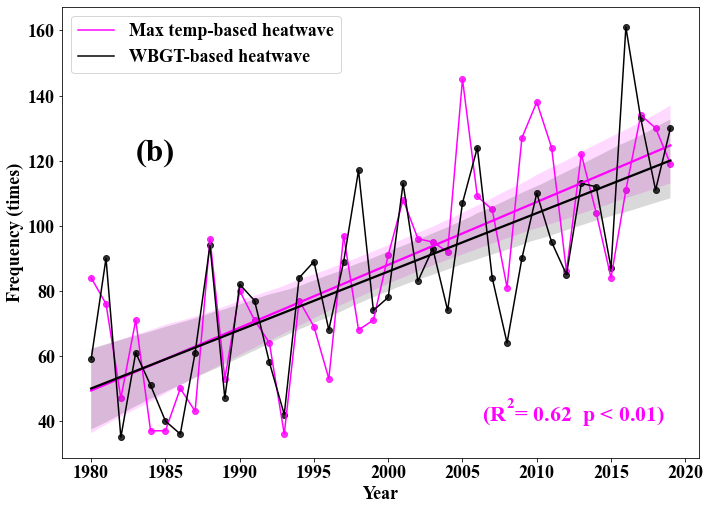

In [13]:
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"

fig, ax = plt.subplots(figsize=(10,7))
matplotlib.rcParams['font.size'] = 18.0

plt.rcParams['font.sans-serif'] = 'Times New Roman'
plt.subplots_adjust(left=0.09, right=0.975, top=0.995, bottom=0.1)


color = "fuchsia"

g = sns.lineplot(data=data, x="Year",y="发生频次",color=color,label='Max temp-based heatwave')
g = sns.regplot(data=data, x="Year",y="发生频次",color=color)

g = sns.lineplot(x="Year",y="Frequency (times)",data=data,color="black",label='WBGT-based heatwave')
g = sns.regplot(data=data, x="Year",y="Frequency (times)",color="black")

# text_Yellow = '($\mathregular{R^2}$= '+  str(round(R2_Yellow, 2))+'  p < 0.01) '
# text_Orange = ' ($\mathregular{R^2}$= '+  str(round(R2_Orange, 2))+'  p < 0.01) '
text_Red = ' ($\mathregular{R^2}$= '+  str(round(R2_Red, 2))+'  p < 0.01) '


# plt.text(x=1994,y=190, s= text_Yellow, size=18, color = 'gold')
# plt.text(x=1994,y=212, s= text_Orange, size=18, color = 'orange')
plt.text(x=2006,y=40, s= text_Red, size=22, color = color)

# plt.legend( bbox_to_anchor=(1.03, 0), loc=3, borderaxespad=0)
# plt.legend(loc=4)
plt.legend()
plt.text(x=1983,y=120 , s= "(b)", size=32, color = 'black',fontweight='bold')

plt.savefig('12-b-热浪对比.jpg', dpi=300)
plt.show()